In [127]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import datetime as dt
from sklearn import model_selection, metrics
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
%matplotlib inline

## Loading data and building features

In [128]:

# Load dataset 
train = pd.read_csv('asset/train.csv')
test = pd.read_csv('asset/test.csv')
sample = pd.read_csv('asset/sampleSubmission.csv')
weather = pd.read_csv('asset/weather.csv')
spray = pd.read_csv('asset/spray.csv')

# Get labels
labels = train.WnvPresent.values

# Creating dummy variables for the weather data
weather.CodeSum = weather.CodeSum.apply(str.split)
for (i,list_) in enumerate(weather.CodeSum):
    for item in list_:
        if item not in weather.columns:
            weather[item] = 0
        weather.set_value(col=item,index=i,value=1)


# Not using codesum anymore
weather = weather.drop('CodeSum', axis=1)
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)


In [129]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', 0)
weather = weather.replace(' T', 0)
weather = weather.replace('  T', 0)

In [130]:
weather['yoni_interaction_term'] = (weather.DewPoint_x)/(weather.Tavg_x.apply(float))
#weather['yoni_interaction_term_y'] = (weather.DewPoint_y)/(weather.Tavg_y.apply(float))

In [131]:
# Taking derivities of some columns
weather['tmax_diff'] = weather.Tmax_x.diff()
weather['dewpoint_diff'] = weather.DewPoint_x.diff()
weather['tmin_diff'] = weather.Tmin_x.diff()
#weather['wetbulb_diff'] = weather.WetBulb_x().apply(float).diff()
weather['precip_diff'] = weather.PrecipTotal_x.apply(float).diff()
weather['tavg_diff'] = weather.Tavg_x.apply(float).diff()

In [132]:
# Functions to extract month and day from dataset
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day'] = train['Date'].dt.day
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day

In [133]:
# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [134]:
# This method merges the weather df with a dataframe and does so mulitple times by days for the given amount
# of days
def merge_weather_previous_days(df, days, df_weather = weather):
    for i in range(1, days):
        date_col = 'Date'+ '_' + str(i)
        if(i == 0):
            date_col = 'Date'
        df[date_col] = df.Date.apply(lambda a: a - pd.Timedelta(days=1))
        df = df.merge(weather, left_on=date_col, right_on='Date', suffixes=("","_day_" + str(i)))
    return df


def merge_weather_previous_weeks(df, weeks, df_weather = weather):
    for i in range(1, weeks):
        date_col = 'Date'+ '_' + str(i)
        if(i == 0):
            date_col = 'Date'
        df[date_col] = df.Date.apply(lambda a: a - pd.Timedelta(weeks=1))
        df = df.merge(weather, left_on=date_col, right_on='Date', suffixes=("","_week_" + str(i)))
    return df


# #This method is attempting to take the mean of weather over a weekly period, and append that values to our DF
# def agg_by_week(df, df_weather = weather):
#     # grouping data in weather column by week and taking the average.
#     # i'm going to use this data to build columns in the passed in data frame that has the average value
#     # of the 
#     agg_weather = df_weather.set_index('Date').groupby(pd.TimeGrouper('W')).mean()
#     for d in agg_weather.index:
#         for c in agg_weather:
#             if c not in df.columns:
#                 df[c] = agg_weather.get_value(d, c)
#             for j in range(1, len(df)):
#                 if df.get_value(j, "Date") < d:
#                     if df.get_value(j-1, "Date") > d:
#                         df.set_value(j, c, agg_weather.get_value(d,c))
#                 else:
#                     break
                    
#This method is attempting to take the mean of weather over a weekly period, and append that values to our DF
def agg_by_week(df, df_weather = weather):
    # grouping data in weather column by week and taking the average.
    # i'm going to use this data to build columns in the passed in data frame that has the average value
    # of the 
    for i in range(0, len(df)):
        df_date = df.get_value(i, 'Date')
        agg_weather = df_weather.set_index('Date').groupby(pd.TimeGrouper('W')).mean()
        for c in agg_weather.columns:
            col_name = c+ "_agg"
            if c.startswith('codesum'):
                continue
            if c not in df.columns:
                df[col_name] = -1
            value =  agg_weather[c][(agg_weather.index < df_date) & 
                                (agg_weather.index > df_date - pd.Timedelta(weeks=1))][0]
            #print(value)
            if np.isnan(value):
                value = -1
            df.set_value(i, col_name, value)

In [135]:
#agg_by_week(train)
train.isnull().sum().nlargest(300)

Date               0
Species            0
Block              0
Street             0
Trap               0
Latitude           0
Longitude          0
AddressAccuracy    0
year               0
month              0
day                0
dtype: int64

In [136]:
# Putting historical weather data onto the data frame
train = merge_weather_previous_days(train, 3, weather)
test =  merge_weather_previous_days(test, 4, weather)

train = merge_weather_previous_weeks(train, 3, weather)
test =  merge_weather_previous_weeks(test, 4, weather)



In [138]:
# This function allows you to create columns for the data_df input that will have a value of 1 or zero
# If a trap has been sprayed with in the time period specified

def create_sprayed_cols(data_df, spray_df, time_period=2):
    # Iterating over unique dates that sprays took place
    # Sprays took place over 10 days as trucks drove around chicago
    for date in set(spray_df.Date):
        # I only want data for this unique date
        spray_temp = spray_df[spray_df.Date == date]
        # Resetting index to make iterating easier
        spray_temp.index = range(0, len(spray_temp))
        
        # I am creating a column for every unique date and initalizing it's rows to 0
        # I will set these values to 1 when I find a trap that was sprayed
        col_name = 'spray_'+date.strftime('%Y-%m-%d')+"_"+str(time_period)
        data_df[col_name] = 0
        # Iterating over each row of our training data to determine if a trap is in the location
        # of a spray. I am also checking to see if the spray was in the past
        for r in range(0,len(data_df)):
            if data_df.get_value(r,'Date') > date and data_df.get_value(r,'Date') < date + pd.Timedelta(weeks=time_period):

                # I am casting the lat and long to ints, and multiplaying by 100 to truncate precision
                # In other words, I'm taking pin points and making them into squares
                cur_lat = int(data_df.get_value(r, 'Latitude') * 100)
                cur_long = int(data_df.get_value(r, 'Longitude') * 100)
                
                # Iterating over each value in my spray data
                for i in range(0, len(spray_temp)):
                    
                    spray_lat = int(spray_temp.get_value(i,'Latitude')*100)
                    spray_long = int(spray_temp.get_value(i,'Longitude')*100)
                    
                    latdiff = spray_lat - cur_lat
                    longdiff = spray_long - cur_long
                    dis = .5 **(latdiff ** 2 + longdiff ** 2)
                    
                    # I am now checking if something is in the square +/- some threshold
                    if (cur_lat < spray_lat + 10 and cur_lat > spray_lat - 10) and \
                    (cur_long < spray_long + 10 and cur_long > spray_long - 10):
                        print(dis)
                        data_df.set_value(r,col_name, 1)
                        break

In [ ]:
# adding spray data
create_sprayed_cols(train, spray, time_period=2)
create_sprayed_cols(test,spray, time_period=2)

In [ ]:
#Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

# Converting data to catagoreical data. Instead of using the label encoder
train = pd.get_dummies(train, prefix = ['Trap', 'Species', 'Block', 'Street'],\
                                      columns=['Trap','Species','Block','Street'])
test = pd.get_dummies(test, prefix = ['Trap', 'Species','Block','Street'],\
                                     columns=['Trap','Species', 'Block', 'Street'])


In [ ]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]
test = test.loc[:,(test != -1).any(axis=0)]

In [ ]:
# Making everything numerical if it is a string
train = train.convert_objects(convert_numeric=True)
test = test.convert_objects(convert_numeric=True)

In [ ]:
# Converting data to polar coordinates. This may help location become a better predictor.

epicenter_lat = 41.903002
epicenter_long = -87.688267

epicenter_rho = np.sqrt(epicenter_lat**2 + epicenter_long**2)
epicenter_phi = np.arctan2(epicenter_long, epicenter_lat)

train['rho'] = np.sqrt((train['Latitude'] - epicenter_lat)**2 + (train['Longitude'] - epicenter_long)**2)
train['phi'] = np.arctan2(train['Longitude'], train['Latitude'])
test['rho'] = np.sqrt((test['Latitude'] - epicenter_lat)**2 + (test['Longitude'] - epicenter_long)**2)
test['phi'] = np.arctan2(test['Longitude'], test['Latitude'])

In [ ]:
train = train.drop(train[list(filter(lambda a: a.startswith('Date'), train.columns))], axis=1)
test = test.drop(test[list(filter(lambda a: a.startswith('Date'), test.columns))], axis=1)
train = train.drop(['Latitude', 'Longitude'], axis=1)
test = test.drop(['Latitude', 'Longitude'], axis=1)
train = train.drop(set(train.columns) - set(test.columns), axis=1)
test = test.drop(set(test.columns) - set(train.columns), axis=1)

## Saving data to CSV to spped up future model building.

In [ ]:
train.to_csv('train_w_weather.csv', index=False)
test.to_csv('test_w_weather.csv', index=False)

In [ ]:
# train = pd.read_csv('train_w_weather.csv')
# test = pd.read_csv('test_w_weather.csv')

# labels = train.WnvPresent.values

# Grid searching below

In [ ]:
# # method to help fit with xgboost

# def modelfit(alg, X,y, predictors=None,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
#     if predictors == None:
#         predictors = X.columns
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X[predictors].values, label=y)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(X[predictors].values,y,eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(X[predictors].values)
#     dtrain_predprob = alg.predict_proba(X[predictors].values)[:,1]
        
#     #Print model report:
#     print ("\nModel Report")
#     print ("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     print(feat_imp)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    

In [ ]:
#predictors = [x for x in train.columns if x not in [target, IDcol]]
# xgb1 = xgb.XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
#modelfit(xgb1, train_xgb, labels)


In [ ]:

features = train.columns
xgb1 = xgb.XGBClassifier()
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[8], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [2],
              'min_child_weight': [1],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'n_estimators': [3000], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'seed': [123]}

clf = model_selection.GridSearchCV(xgb1, parameters, n_jobs=6, 
                   cv=model_selection.StratifiedKFold(n_splits=3, random_state=None, shuffle=True
                                                     ), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train[features], labels)
model = clf.best_estimator_

In [ ]:

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(test[features])[:,1]

predictions = clf.predict_proba(test[features])[:,1]
sample['WnvPresent'] = predictions
sample.to_csv('beat_the_benchmark.csv', index=False)
model = clf.best_estimator_
# sample = pd.read_csv('../input/sample_submission.csv')
# sample.QuoteConversion_Flag = test_probs
# sample.to_csv("xgboost_best_parameter_submission.csv", index=False)



In [113]:
features

Index(['AddressAccuracy', 'year', 'month', 'day', 'Tmax_x', 'Tmin_x', 'Tavg_x',
       'Depart_x', 'DewPoint_x', 'WetBulb_x',
       ...
       'Street_131', 'Street_132', 'Street_133', 'Street_134', 'Street_135',
       'Street_136', 'Street_137', 'Street_138', 'rho', 'phi'],
      dtype='object', length=627)

In [114]:

# # fit model no training data
# model = xgb.XGBClassifier()
# model.fit(X=train.values, y=labels, eval_metric='auc')


# model.score(X=train.values, y=labels)
# # param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }

# # # specify validations set to watch performance
# # watchlist  = [(labels,'eval'), 
# #               (train.values,'train')]
# # num_round = 2
# # bst = xgb.train(param, 
# #                 train.values, 
# #                 num_round, 
# #                 watchlist)

# cvresult = xgb.cv(xgb_param, test, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
#         alg.set_params(n_estimators=cvresult.shape[0])



In [115]:
# # n_estimators = [500]
# # criterion = ['entropy']
# # max_depth = [2,4,7]
# # min_samples_split = [2,3]
# # max_features = ['auto', 'log2',50]
# # clf = ensemble.RandomForestClassifier()
# # Random Forest Classifier 
# # grid = model_selection.GridSearchCV(estimator=clf, scoring='roc_auc', param_grid=dict(n_estimators=n_estimators, criterion=criterion,
# #                                                     max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split))

# param_grid = {'Cs': [[0.001, 0.01, 0.1, 1, 10, 100, 1000]]}
# grid = model_selection.GridSearchCV(linear_model.LogisticRegressionCV(penalty='l2',scoring='roc_auc', class_weight='balanced'), param_grid)
# grid.fit(train,labels)

### Evaluating results

In [116]:
# #grid.best_estimator_.fit(train, labels)

# # create predictions and submission file
# #predictions = grid.best_estimator_.predict_proba(test)[:,1]
# predictions = xgb1.predict_proba(test.values)
# sample['WnvPresent'] = predictions
# sample.to_csv('beat_the_benchmark.csv', index=False)

In [ ]:
np.mean(model_selection.cross_val_score(model, X=train, y=labels, scoring='roc_auc', n_jobs=5))

#### Looking at feature importances

Feature ranking:
phi: 0.09461476653814316
rho: 0.09208864718675613
Sunrise_x: 0.02893558330833912
yoni_interaction_term: 0.015156734734773636
yoni_interaction_term_week_1: 0.014697439037263393
AvgSpeed_x_week_1: 0.012630611658096313
ResultSpeed_y_week_1: 0.012515787966549397
Species_2: 0.012171316891908646
ResultSpeed_y: 0.012056493200361729
Species_3: 0.011482374742627144
AvgSpeed_y_week_1: 0.011023079976439476
AddressAccuracy: 0.010908256284892559
Species_1: 0.009989665821194649
tmin_diff_week_1: 0.009645194746553898
ResultDir_x: 0.009645194746553898
day: 0.009071076288819313
dewpoint_diff: 0.008726604282855988
ResultSpeed_x_week_1: 0.008152485825121403
AvgSpeed_y: 0.007693191058933735
tavg_diff_week_1: 0.007463543675839901
DewPoint_x: 0.007348719518631697
AvgSpeed_x: 0.00723389582708478
ResultDir_x_week_1: 0.006889424752444029
ResultDir_y: 0.006889424752444029
ResultSpeed_x: 0.006889424752444029
dewpoint_diff_week_1: 0.006774601060897112
tmax_diff: 0.006774601060897112
Trap_147: 0.0

Street_76: 0.0
Street_75: 0.0
Street_73: 0.0
Street_70: 0.0
Street_67: 0.0
Street_66: 0.0
Street_61: 0.0
Street_60: 0.0
Street_59: 0.0
Street_56: 0.0
Street_51: 0.0
Street_47: 0.0
Street_46: 0.0
Street_45: 0.0
Street_41: 0.0
Street_38: 0.0
Street_37: 0.0
Street_33: 0.0
Street_31: 0.0
Street_30: 0.0
Street_29: 0.0
Street_27: 0.0
Street_23: 0.0
Street_22: 0.0
Street_17: 0.0
Street_16: 0.0
Street_15: 0.0
Street_14: 0.0
Street_13: 0.0
Street_12: 0.0
Street_11: 0.0
Street_10: 0.0
Street_9: 0.0
Street_7: 0.0
Street_2: 0.0
Block_98: 0.0
Block_96: 0.0
Block_93: 0.0
Block_81: 0.0
Block_80: 0.0
Block_75: 0.0
Block_73: 0.0
Block_68: 0.0
Block_66: 0.0
Block_55: 0.0
Block_53: 0.0
Block_43: 0.0
Block_34: 0.0
Block_29: 0.0
Block_27: 0.0
Block_20: 0.0
Block_18: 0.0
Species_5: 0.0
Species_0: 0.0
Trap_146: 0.0
Trap_145: 0.0
Trap_144: 0.0
Trap_137: 0.0
Trap_132: 0.0
Trap_127: 0.0
Trap_123: 0.0
Trap_119: 0.0
Trap_115: 0.0
Trap_114: 0.0
Trap_110: 0.0
Trap_109: 0.0
Trap_107: 0.0
Trap_106: 0.0
Trap_105: 0.0


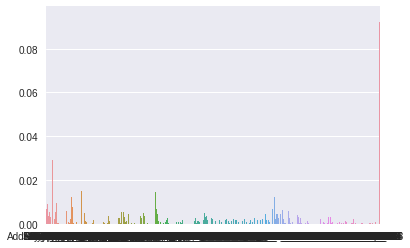

In [118]:
# Zipping feature importances and sorting by how importnat they are
importances = list(zip(train.columns,model.feature_importances_))
#importances = list(zip(best_features,model.feature_importances_))
importances.sort(key=lambda a: a[1])
importances = importances[::-1]
# std = np.std([model.feature_importances_ for tree in model.estimators_],
#              axis=0)

# Print the feature ranking
print("Feature ranking:")

for f in range(0, len(importances)):
    print("{}: {}".format(importances[f][0], importances[f][1]))

# Plot the feature importances of the forest
sns.barplot(x=train.columns, y=model.feature_importances_)


In [109]:
best_features = [ x[0] for x in list(filter(lambda a : a[1] >0, importances))]

In [110]:
for i in importances

[('phi', 0.089348286),
 ('rho', 0.072529785),
 ('Sunrise_x', 0.050805885),
 ('yoni_interaction_term', 0.019971969),
 ('Species_3', 0.016117729),
 ('DewPoint_x', 0.016117729),
 ('year', 0.015767343),
 ('Species_6', 0.01226349),
 ('yoni_interaction_term_week_1', 0.011913104),
 ('AvgSpeed_y_week_1', 0.011212333),
 ('ResultSpeed_y', 0.011212333),
 ('tmin_diff_week_1', 0.010511563),
 ('AvgSpeed_x_week_1', 0.010511563),
 ('dewpoint_diff', 0.010511563),
 ('ResultDir_y', 0.010511563),
 ('ResultSpeed_y_week_1', 0.010161177),
 ('Species_1', 0.0094604064),
 ('day', 0.0091100214),
 ('Species_2', 0.0087596355),
 ('Trap_148', 0.0084092505),
 ('Trap_133', 0.0084092505),
 ('AddressAccuracy', 0.0080588646),
 ('Sunset_x', 0.0077084792),
 ('Trap_147', 0.0073580937),
 ('Trap_4', 0.0073580937),
 ('dewpoint_diff_week_1', 0.0073580937),
 ('Tavg_x_week_1', 0.0070077083),
 ('Block_58', 0.0066573229),
 ('Trap_143', 0.0066573229),
 ('Trap_138', 0.0066573229),
 ('SeaLevel_x', 0.0066573229),
 ('Tmax_x_week_1', 0.0

In [104]:


train = pd.read_csv('train_w_weather.csv')
test = pd.read_csv('test_w_weather.csv')